# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [3]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN


## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
# Зачем передаем в Clustering параметры из sklearn ?????
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.neighbors import KDTree

class Clustering(BaseEstimator, ClusterMixin):
    """
    Clustering algorithm
    """

    def __init__(self, epsilon=0.5, min_pts=2):
        """
        Algorithm parameters:
        epsilon
        min_pts
        """
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.noise = []
        self.clusters = {}
        self.clustered = []
        return

    def neighbours(self, obj, X, kind='kd-tree'):

        if kind == 'simple':
            return [obj_1.tolist() for obj_1 in X if np.linalg.norm(np.array(obj) - obj_1) < self.epsilon]
        if kind == 'kd-tree':
            tree = KDTree(X, leaf_size=2)
            ind = tree.query_radius(np.array(obj).reshape(1, -1), r=self.epsilon).tolist()
            return X[tuple(ind)].tolist()


    def expand_cluster(self, obj, C, nbrs, NV, x):

        self.clusters[C].append(obj)
        self.clustered.append(obj)
        for nbr in nbrs:
            if nbr in NV:  # object not visited
                NV.remove(nbr)  # mark as visited
                nbr_nbrs = self.neighbours(nbr, x)
                if len(nbr_nbrs) >= self.min_pts:
                    for each in nbr_nbrs:
                        if each not in nbrs:
                            nbrs.append(each) # join sets of neighbours
                if nbr not in self.clustered:
                    self.clusters[C].append(nbr)
                    self.clustered.append(nbr)
                if nbr in self.noise:
                    ind = (self.noise == nbr).all(axis=1).nonzero()
                    np.delete(self.noise, ind, 0)

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        C = 0
        NV = x.tolist()  # not visited objects
        while len(NV) !=0:
            for obj in NV:
                NV.remove(obj)  # mark as visited
                nbrs = self.neighbours(obj, x)  # list of neighbours
                if len(nbrs) < self.min_pts:
                    self.noise.append(obj)  # mark as noise
                else:
                    self.clusters[C] = []
                    self.expand_cluster(obj, C, nbrs, NV, x)
                    C += 1

        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        clusters_vec = []
        for p in x:
            if p.tolist() in self.noise:
                clusters_vec.append(-1) # mark noise as -1
            else:
                [clusters_vec.append(num) for num, points in self.clusters.items() if p.tolist() in points]

        return clusters_vec

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

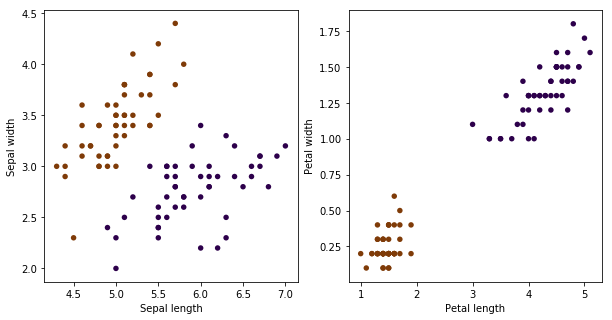

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Sepal length')
pl.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Petal length')
pl.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [6]:
pred_iris = Clustering(epsilon=.5, min_pts=3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.87


In [7]:
pred_iris = Clustering(epsilon=0.65, min_pts=2).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

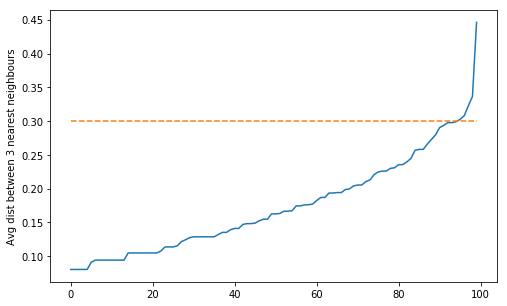

In [8]:
def params(X, y=None, minpts=3):
    avgs = []
    for x in X:
        tree = KDTree(X, leaf_size=2)
        dist, ind = tree.query(x.reshape(1, -1), k=minpts) 
        
        avg=np.sum(dist)/minpts
        avgs.append(avg)
    
    return np.sort(np.array(avgs))

pl.figure(figsize=(8, 5))
pl.plot(params(x_iris))
pl.plot(np.ones(100)*0.3,'--')
pl.ylabel("Avg dist between 3 nearest neighbours")
pl.show()

Судя по данному критерию, наилучшим epsilon для нашей задачи будет число примерно равное 0.3. Но так как Adjusted Rand index для epsilon = 0.3 равняется всего лишь 0.37, то будем опираться на критерий, рассчитанный ниже.

In [9]:
pred_iris = Clustering(epsilon=.3, min_pts=3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.37


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

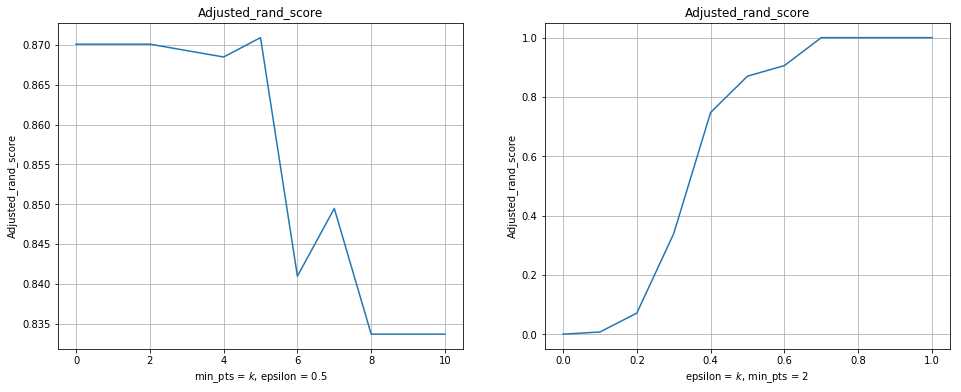

In [10]:
ks = range(11)
criteria = np.zeros(len(ks))
criteria_eps = np.zeros(len(ks))
x = x_iris

for i in ks:
    cls = Clustering(epsilon = 0.5, min_pts = i) 
    y = cls.fit_predict(x)
    criteria[i] = smt.adjusted_rand_score(y_iris, y)

    cls_eps = Clustering(epsilon = i/10, min_pts = 2)  
    y_eps = cls_eps.fit_predict(x)
    criteria_eps[i] = smt.adjusted_rand_score(y_iris, y_eps)
    

fig, [ax1, ax2] = pl.subplots(1, 2, figsize=(16, 6))

ax1.plot(ks, criteria)
ax1.set_title("Adjusted_rand_score")
ax1.set_ylabel("Adjusted_rand_score")
ax1.set_xlabel("min_pts = $k$, epsilon = 0.5")
ax1.grid()

ax2.plot(np.array(ks)/10, criteria_eps)
ax2.set_title("Adjusted_rand_score")
ax2.set_ylabel("Adjusted_rand_score")
ax2.set_xlabel("epsilon = $k$, min_pts = 2")
ax2.grid()

pl.show()

Оптимальное сочетание параметров: epsilon = 0.65, min_pts = 2

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

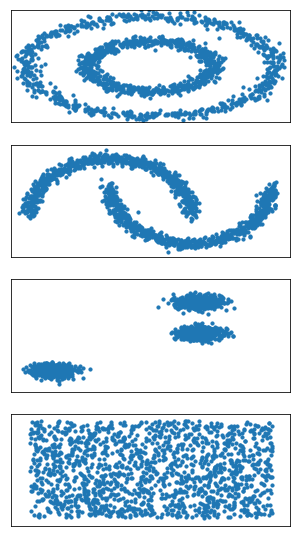

In [11]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

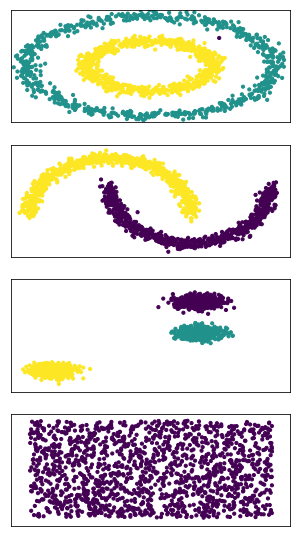

In [12]:
plt.figure(figsize=(2 + 3, 9.5))
plt.title('My DBSCAN')

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    cls = Clustering(epsilon=0.25, min_pts=3)
    y_pred = cls.fit_predict(X)
    
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

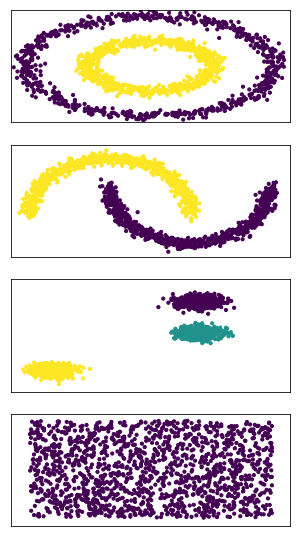

In [13]:
from sklearn import cluster

plt.figure(figsize=(2 + 3, 9.5))
plt.title('Sklearn DBSCAN')

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    dbscan = cluster.DBSCAN(eps=0.3)
    dbscan_pred = dbscan.fit_predict(X)
    
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=dbscan_pred)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.

In [14]:
# ==========================================
# Used the "World University Rankings" dataset from Kaggle
# ==========================================

# world_rank - world rank for university.
# institution - name of university
# country - country of each university
# national_rank - rank of university within its country
# quality_of_education - rank for quality of education
# alumni_employment - rank for alumni employment
# quality_of_faculty - rank for quality of faculty
# publications - rank for publications
# influence - rank for influence
# citations - number of students at the university
# broad_impact - rank for broad impact (only available for 2014 and 2015)
# patents - rank for patents
# score - total score, used for determining world rank
# year - year of ranking (2012 to 2015)

df = pd.read_csv(r'/Users/mary/Desktop/Otus/Module 2/HW2/world-university-rankings/cwurData.csv')


In [15]:
df.head(7)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012
5,6,Princeton University,USA,5,8,14,2,53,33,26,NaN,101,82.50,2012
6,7,University of Oxford,United Kingdom,2,13,28,9,15,13,19,NaN,26,82.34,2012


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
world_rank              2200 non-null int64
institution             2200 non-null object
country                 2200 non-null object
national_rank           2200 non-null int64
quality_of_education    2200 non-null int64
alumni_employment       2200 non-null int64
quality_of_faculty      2200 non-null int64
publications            2200 non-null int64
influence               2200 non-null int64
citations               2200 non-null int64
broad_impact            2000 non-null float64
patents                 2200 non-null int64
score                   2200 non-null float64
year                    2200 non-null int64
dtypes: float64(2), int64(10), object(2)
memory usage: 240.7+ KB


In [21]:
X = df[df.year == 2015].iloc[:, 4:12]

In [30]:
from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X.values),columns=['quality_of_education',
                                                          'alumni_employment',
                                                          'quality_of_faculty',
                                                          'publications',
                                                          'influence',
                                                          'citations',
                                                          'broad_impact',
                                                          'patents'])
# X['citations'] = StandardScaler().fit_transform(X.citations.values.reshape(-1,1))

In [31]:
X

,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents
0,-2.739560,-2.172250,-3.599935,-1.730395,-1.731660,-1.787295,-1.728171,-1.772057
1,-2.666221,-2.166894,-3.544051,-1.716535,-1.724723,-1.779357,-1.717711,-1.746673
2,-2.721225,-2.118685,-3.581307,-1.681887,-1.728191,-1.783326,-1.724684,-1.779309
3,-2.730392,-2.124042,-3.525423,-1.695747,-1.714318,-1.743638,-1.686332,-1.608875
4,-2.684555,-2.107972,-3.432283,-1.709606,-1.693508,-1.763482,-1.700278,-1.728542
5,-2.629551,-2.145468,-3.450911,-1.688817,-1.690039,-1.747606,-1.689818,-1.768430
6,-2.702890,-2.065120,-3.506795,-1.699211,-1.721255,-1.775388,-1.707251,-1.677774
7,-2.647886,-2.102616,-3.469539,-1.674958,-1.679634,-1.743638,-1.654953,-1.271633
8,-2.712058,-2.097259,-3.562679,-1.484393,-1.648419,-1.696012,-1.616600,-0.967028
9,-2.638719,-2.081190,-3.357770,-1.650704,-1.683103,-1.692043,-1.654953,-1.743047


In [32]:
# Try 3 clustering algorythms
# 1. DBSCAN
Y_plot = params(X.values)

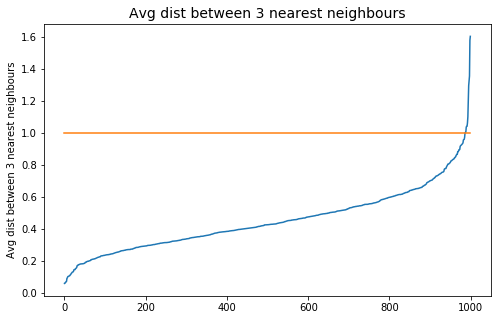

In [33]:
pl.figure(figsize=(8, 5))
pl.plot(Y_plot)
pl.ylabel("Avg dist between 3 nearest neighbours")
pl.title("Avg dist between 3 nearest neighbours", fontsize = 14)
pl.plot(np.ones(1000),'-')
pl.show()

In [34]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 1)
Y = dbscan.fit_predict(X)

In [35]:
# pl.scatter(X['influence'], X['quality_of_faculty'], c=Y)

In [36]:
# 2. K-means

from sklearn.cluster import KMeans
from sklearn import metrics

inertia = []
k = range(1, 30)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    inertia.append(km.inertia_)

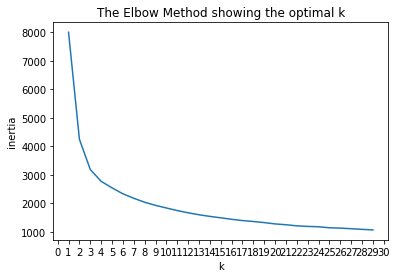

In [37]:
pl.plot(k, inertia);
pl.xlabel('k');
pl.ylabel('inertia');
pl.xticks(np.arange(31));
pl.title('The Elbow Method showing the optimal k');

Судя по графику, оптимальным количеством кластеров в данном случае будет 3-4 кластера. Аналагичный вывод можем сделать по дендрограмме ниже(судя по дендрограмме можем взять и 5 кластеров)

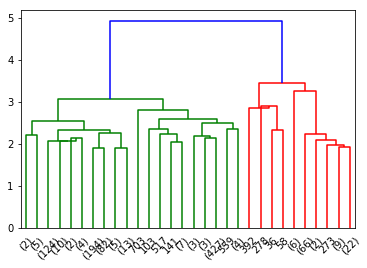

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='centroid', metric='euclidean')

fig, ax = plt.subplots(1, 1)
dend = dendrogram(Z, ax=ax, truncate_mode='lastp')

In [39]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

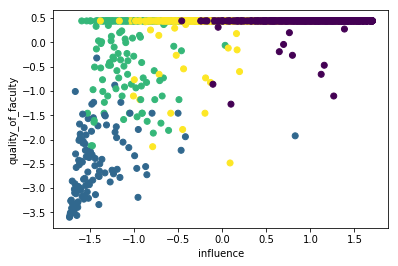

In [64]:
pl.scatter(X['influence'], X['quality_of_faculty'], c=kmeans.labels_);
plt.xlabel('influence');
plt.ylabel('quality_of_faculty');

Заметим сразу, что чем показатель ниже - тем лучше, поскольку мы имеем дело с рангами ВУЗов.

На примере пары признаков "влияние" и "качество образования на факультетах" можно проинтерпретировать кластеры так: 

1) ВУЗы, степень влияния которых ниже среднего, и качество факультета так же низко

2) ВУЗы, качество образования в которых среднее и ниже среднего, качество факультета среднее или низкое

3) Влиятельные ВУЗы со средним и низким качеством образования

4) и самые влиятельные ВУЗы с  самым высоким качеством образования

In [41]:
# 3. GMM
from sklearn.mixture import GaussianMixture

np.random.seed(1)

gmm = GaussianMixture(n_components = 4) 
gmm.fit(X) 
labels = gmm.predict(X) 

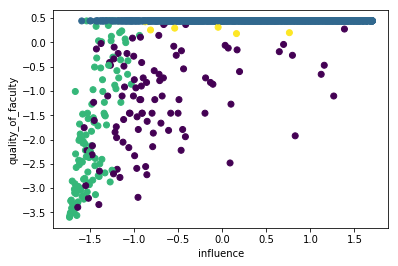

In [63]:
plt.scatter(X['influence'], X['quality_of_faculty'], c=labels);
plt.xlabel('influence');
plt.ylabel('quality_of_faculty');

Результат EM-кластеризации отличается от предыдущих. 

* Здесь четко выделяется кластер ВУЗов с высоким влиянием, где качество обучения может быть как низким, так и высоким(№2, зеленый). Примеры: Oxford, Cambridge, MIT.
* В кластере №0(фиолетовый) влияние преимущественно выше среднего, а качество как низкое, так и высокое. Пример: Hebrew University of Jerusalem (Israel).
* 1-й кластер (синий) включает в себя ВУЗы с исключительно низким качеством обучения, имеющие как слабое, так и сильное влияние. Примеры: Novosibirsk State University, China Pharmaceutical University.
* И каластер №3 (желтый) аналогичный 1-му, но допускает также ВУЗы с более хорошим образованием на факультетах. Пример: Seoul National University

In [60]:
df.loc[df.year == 2015, 'label'] = labels

In [68]:
df_temp = pd.concat((X, df.loc[df.year == 2015].reset_index()[['institution', 'label']]), axis=1)
df_temp

,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,institution,label
0,-2.739560,-2.172250,-3.599935,-1.730395,-1.731660,-1.787295,-1.728171,-1.772057,Harvard University,2.0
1,-2.666221,-2.166894,-3.544051,-1.716535,-1.724723,-1.779357,-1.717711,-1.746673,Stanford University,2.0
2,-2.721225,-2.118685,-3.581307,-1.681887,-1.728191,-1.783326,-1.724684,-1.779309,Massachusetts Institute of Technology,2.0
3,-2.730392,-2.124042,-3.525423,-1.695747,-1.714318,-1.743638,-1.686332,-1.608875,University of Cambridge,2.0
4,-2.684555,-2.107972,-3.432283,-1.709606,-1.693508,-1.763482,-1.700278,-1.728542,University of Oxford,2.0
5,-2.629551,-2.145468,-3.450911,-1.688817,-1.690039,-1.747606,-1.689818,-1.768430,Columbia University,2.0
6,-2.702890,-2.065120,-3.506795,-1.699211,-1.721255,-1.775388,-1.707251,-1.677774,"University of California, Berkeley",2.0
7,-2.647886,-2.102616,-3.469539,-1.674958,-1.679634,-1.743638,-1.654953,-1.271633,University of Chicago,2.0
8,-2.712058,-2.097259,-3.562679,-1.484393,-1.648419,-1.696012,-1.616600,-0.967028,Princeton University,2.0
9,-2.638719,-2.081190,-3.357770,-1.650704,-1.683103,-1.692043,-1.654953,-1.743047,Cornell University,2.0
